Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

In [1]:
NAME = "Hanmaro Song"
COLLABORATORS = ""

---

In [2]:
import os
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

sns.set(style="whitegrid", palette="muted")

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

%matplotlib inline

# Project 2: NYC Taxi Rides
# Extras

Put all of your extra work in here. Feel free to save figures to use when completing Part 4.

In [3]:
# Copied from part 2
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

# Copied from part 2
def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Compute Manhattan distance
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

# Copied from part 2
def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# Copied from part 2
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
    return df

# Copied from part 2
def add_distance_columns(df):
    """
    Add distance features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    return df

def select_columns(data, *columns):
    return data.loc[:, columns]

def remove_col(df):
    return df.drop(['date', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'bearing'], axis=1)


In [4]:
def preprocess(train_df, collisions=None, test=False):
    
    
    train_df = train_df.loc[train_df['fare_amount'] <= train_df['fare_amount'].quantile(0.95)]
    
    if not test:
        train_df['date'] = train_df['tpep_pickup_datetime'].dt.date
        train_df = train_df[['date', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'duration']]
        train_df = train_df.drop(['tpep_dropoff_datetime'], axis=1)
        train_df = train_df.loc[train_df['duration'] <= train_df['duration'].quantile(0.99)]
    else:
        train_df['date'] = train_df['tpep_pickup_datetime'].dt.date
        train_df = train_df[['date', 'tpep_pickup_datetime', 'trip_distance', 'fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
#         train_df = train_df.drop(['date', 'tpep_pickup_datetime'], axis=1)
    
    train_df = add_distance_columns(train_df)
    train_df = train_df.drop(['bearing'], axis=1)
    
    
    if collisions is not None:
        collisions['SEVERITY'] = collisions.filter(regex=r'NUMBER OF *').sum(axis=1)
        collisions['FATALITY'] = collisions.filter(regex=r'KILLED').sum(axis=1)
        collisions['INJURY'] = collisions.filter(regex=r'INJURED').sum(axis=1)
        collisions['DATE'] = collisions['DATETIME'].dt.date
        collisions = collisions[['DATETIME', 'DATE', 'LATITUDE', 'LONGITUDE', 'SEVERITY']]

    return train_df, collisions



In [5]:
def merge(df):
    
    merged = collisions.merge(df, how='right', left_on='DATE', right_on='date')
    merged['START'] = merged['DATETIME']
    merged['END'] = merged['START'] + pd.Timedelta(hours=1)
    
    start_to_accident = haversine(merged['pickup_latitude'].values,
                              merged['pickup_longitude'].values,
                              merged['LATITUDE'].values,
                              merged['LONGITUDE'].values)
    merged['start_to_accident'] = start_to_accident
    merged['accident_close'] = 0

    is_accident_close = (merged['start_to_accident'] <= 5) & (merged['tpep_pickup_datetime'] >= merged['START']) & (merged['tpep_pickup_datetime'] <= merged['END'])
    merged.loc[is_accident_close, 'accident_close'] = 1
    
    merged = merged.drop(['DATETIME', 'DATE', 'LATITUDE', 'LONGITUDE', 'date', 'START', 'END'], axis=1)
    
    return merged

In [6]:
# Run this cell to load the data. 
data_file = Path("./", "cleaned_data.hdf")
collisions_dir = Path('data/collisions')
skiprows = None

train_df = pd.read_hdf(data_file, "train")
val_df = pd.read_hdf(data_file, "val")

collisions = pd.read_csv(collisions_dir/'collisions_2016.csv', index_col='UNIQUE KEY', 
                         parse_dates={'DATETIME':["DATE","TIME"]}, skiprows=skiprows)

test_df = pd.read_csv("./proj2_test_data.csv")
test_df['tpep_pickup_datetime'] = pd.to_datetime(test_df['tpep_pickup_datetime'])

In [7]:
train_df, collisions = preprocess(train_df, collisions)
train_df['date'] = pd.to_datetime(train_df['date'])
train_df = train_df.loc[(train_df['date'].dt.day != 22) | (train_df['date'].dt.day != 23) | (train_df['date'].dt.day != 24)]

val_df = preprocess(val_df)[0]
test_df = preprocess(test_df, test=True)[0]
test_df['date'] = pd.to_datetime(test_df['date'])

collisions = collisions.dropna()
collisions = collisions.loc[(collisions['SEVERITY'] > 0) & (collisions['SEVERITY'] <= collisions['SEVERITY'].quantile(0.95))]
collisions = collisions.loc[collisions['DATETIME'].dt.month == 1]
collisions['DATE'] = pd.to_datetime(collisions['DATE'])

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [8]:
train = train_df.loc[(train_df['fare_amount'] >= train_df['fare_amount'].quantile(0.05)) & (train_df['fare_amount'] <= train_df['fare_amount'].quantile(0.95))]
train = merge(train_df)
train = train.loc[train['accident_close'] == 1]
temp = train.append(train_df).groupby('tpep_pickup_datetime').mean().fillna(0.0)

test = merge(test_df)
test = test.loc[test['accident_close'] == 1]
test = test.append(test_df).groupby(['tpep_pickup_datetime', 'pickup_longitude']).mean().fillna(0).reset_index().drop('tpep_pickup_datetime', axis=1)
test = test.drop(['accident_close', 'SEVERITY'], axis=1)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
x = temp.drop(['duration'], axis=1)
y = temp['duration']

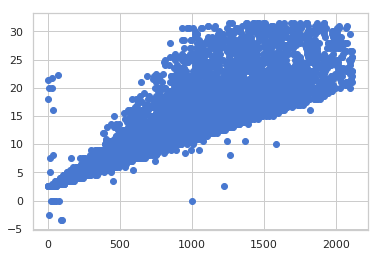

In [10]:
plt.scatter(temp['duration'], temp['fare_amount'])

In [11]:
X_T, X_V, Y_T, Y_V = train_test_split(x, y)

In [12]:
ln = lm.LinearRegression()
ln.fit(X_T, Y_T)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
np.mean(cross_val_score(ln, x, y, cv=5)), np.mean(np.abs(ln.predict(X_V) - Y_V))

(0.94327624000093757, 51.888693272697395)

Elastic gives 148<br>
Linear gives 135

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then,

1. **Submit** the assignment via the Assignments tab in **Datahub** 
1. **Upload and tag** the manually reviewed portions of the assignment on **Gradescope**